### Adapted from Robotics Toolbox for Python: A Tutorial on Manipulator Differential Kinematics

#### Notebook 1: Manipulator Kinematics

github.com/jhavl/dkt

In [2]:
# We will do the imports required for this notebook here

# numpy provides import array and linear algebra utilities
import numpy as np

# the robotics toolbox provides robotics specific functionality
import roboticstoolbox as rtb

# spatial math provides objects for representing transformations
import spatialmath as sm

In [3]:
models_list = rtb.models.list()

┌──────────────┬───────────────────────┬─────────────────────┬──────┬─────┬──────┬────────────────────────────────────────────────────────────┬──────────┬──────────┬──────────────────────────┐
│    class     │         name          │    manufacturer     │ type │ DoF │ dims │                                                  structure │ dynamics │ geometry │         keywords         │
├──────────────┼───────────────────────┼─────────────────────┼──────┼─────┼──────┼────────────────────────────────────────────────────────────┼──────────┼──────────┼──────────────────────────┤
│ Panda        │ Panda                 │ Franka Emika        │ DH   │ 7   │ 3d   │ RRRRRRR                                                    │ Y        │ Y        │                          │
│ Puma560      │ Puma 560              │ Unimation           │ DH   │ 6   │ 3d   │ RRRRRR                                                     │ Y        │ Y        │ dynamics, symbolic, mesh │
│ Stanford     │ Stanford arm      

In [4]:
panda_model = rtb.models.Panda()

panda_model

ERobot: panda (by Franka Emika), 7 joints (RRRRRRR), 1 gripper, geometry, collision
┌──────┬──────────────┬───────┬─────────────┬────────────────────────────────────────────────┐
│ link │     link     │ joint │   parent    │              ETS: parent to link               │
├──────┼──────────────┼───────┼─────────────┼────────────────────────────────────────────────┤
│    0 │ panda_link0  │       │ BASE        │ SE3()                                          │
│    1 │ panda_link1  │     0 │ panda_link0 │ SE3(0, 0, 0.333) ⊕ Rz(q0)                      │
│    2 │ panda_link2  │     1 │ panda_link1 │ SE3(-90°, -0°, 0°) ⊕ Rz(q1)                    │
│    3 │ panda_link3  │     2 │ panda_link2 │ SE3(0, -0.316, 0; 90°, -0°, 0°) ⊕ Rz(q2)       │
│    4 │ panda_link4  │     3 │ panda_link3 │ SE3(0.0825, 0, 0; 90°, -0°, 0°) ⊕ Rz(q3)       │
│    5 │ panda_link5  │     4 │ panda_link4 │ SE3(-0.0825, 0.384, 0; -90°, -0°, 0°) ⊕ Rz(q4) │
│    6 │ panda_link6  │     5 │ panda_link5 │ SE3(90°, -0°, 0

In [5]:
print(panda_model[1])

print(panda_model.qr)
print(panda_model.qz)

Link("panda_link1", SE3(0, 0, 0.333) ⊕ Rz(q), parent="panda_link0", qlim=[-2.9, 2.9])
[ 0.         -0.3         0.         -2.2         0.          2.
  0.78539816]
[0. 0. 0. 0. 0. 0. 0.]



Below is a schematic of a seven degree-of-freedom Franka Emika Panda manipulator. It contains 15 ETs to represent its kinematics.

<img src="https://github.com/jhavl/dkt/blob/main/Part%201/img/cover.png?raw=1" alt="drawing" width="600"/>

Using the ET class we can make all 15 of these ETs in Python


In [6]:
# Note for E7 and E11 in the figure above and code below, we use flip=True
# as the variable rotation is in the negative direction.

E1 = rtb.ET.tz(0.333)
E2 = rtb.ET.Rz()
E3 = rtb.ET.Ry()
E4 = rtb.ET.tz(0.316)
E5 = rtb.ET.Rz()
E6 = rtb.ET.tx(0.0825)
E7 = rtb.ET.Ry(flip=True)
E8 = rtb.ET.tx(-0.0825)
E9 = rtb.ET.tz(0.384)
E10 = rtb.ET.Rz()
E11 = rtb.ET.Ry(flip=True)
E12 = rtb.ET.tx(0.088)
E13 = rtb.ET.Rx(np.pi)
E14 = rtb.ET.tz(0.107)
E15 = rtb.ET.Rz()

# ets1 = rtb.ETS([E1, E2, E3])
# ets2 = ets1 * rtb.ETS([E4, E5, E6])
# print(ets2)

# We can make an ETS representing a Panda by incorporating all 15 ETs into an ETS
panda = E1 * E2 * E3 * E4 * E5 * E6 * E7 * E8 * E9 * E10 * E11 * E12 * E13 * E14 * E15

# View the ETS
print(panda)

tz(0.333) ⊕ Rz(q0) ⊕ Ry(q1) ⊕ tz(0.316) ⊕ Rz(q2) ⊕ tx(0.0825) ⊕ Ry(-q3) ⊕ tx(-0.0825) ⊕ tz(0.384) ⊕ Rz(q4) ⊕ Ry(-q5) ⊕ tx(0.088) ⊕ Rx(180°) ⊕ tz(0.107) ⊕ Rz(q6)


In [7]:
# The ETS class has many useful properties
# print the number of joints in the panda model
print(f"The panda has {panda.n} joints")

# print the number of ETs in the panda model
print(f"The panda has {panda.m} ETs")

# We can access an ET from an ETS as if the ETS were a Python list
print(f"The fifth ET in the ETS is {panda[4]}")

# When a variable ET is added to an ETS, it is assigned a jindex, which is short for joint index
# When given an array of joint coordinates (i.e. joint angles), the ETS will use the jindices of each
# variable ET to correspond with elements of the given joint coordiante array
print(f"The first variable joint has a jindex of {panda[1].jindex}, while the second has a jindex of {panda[2].jindex}")

# We can extract all of the variable ETs from the panda model as a list
print(f"\nAll variable links in the Panda ETS: \n{panda.joints()}")

The panda has 7 joints
The panda has 15 ETs
The fifth ET in the ETS is Rz(q2)
The first variable joint has a jindex of 0, while the second has a jindex of 1

All variable links in the Panda ETS: 
[ET.Rz(jindex=0), ET.Ry(jindex=1), ET.Rz(jindex=2), ET.Ry(jindex=3, flip=True), ET.Rz(jindex=4), ET.Ry(jindex=5, flip=True), ET.Rz(jindex=6)]


In [8]:
qz = np.array([0, 0, 0, 0, 0, 0, 0]) # qz is the zero position of the Panda
qr = np.array([0, -0.3, 0, -2.2, 0, 2, 0.79]) # qr is the ready position of the Panda

# The ETS class has the .fkine method which can calculate the forward kinematics
# The .fkine methods returns an SE3 object
print(f"The fkine method: \n{panda.fkine(qr)}")

# The .eval method also calculates the forward kinematics but returns an numpy array
# instead of an SE3 object (use this if speed is a priority)
print(f"The eval method: \n{panda.eval(qr)}")

The fkine method: 
   0.7003   -0.7068    0.09983   0.4737    
  -0.7104   -0.7038    0         0         
   0.07027  -0.07092  -0.995     0.5155    
   0         0         0         1         

The eval method: 
[[ 7.00329021e-01 -7.06804465e-01  9.98334166e-02  4.73724040e-01]
 [-7.10353272e-01 -7.03845316e-01 -1.22464680e-16 -1.31037208e-17]
 [ 7.02672827e-02 -7.09169942e-02 -9.95004165e-01  5.15513206e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
# panda_model.qz is the zero position of the Panda
# panda_model.qr is the ready position of the Panda

# The ETS class has the .fkine method which can calculate the forward kinematics
# The .fkine methods returns an SE3 object
print(f"The fkine method: \n{panda_model.fkine(panda_model.qr)}")

# The .eval method to calculate the forward kinematics to return an numpy array does not work on pre-loaded models

The fkine method: 
   0.995     0         0.09983   0.484     
   0        -1         0         0         
   0.09983   0        -0.995     0.4126    
   0         0         0         1         



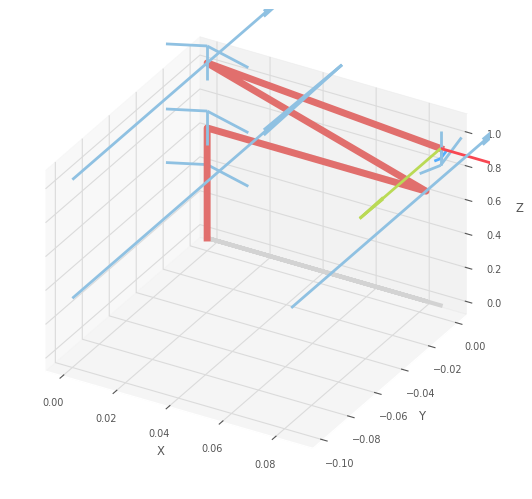

<Figure size 640x480 with 0 Axes>

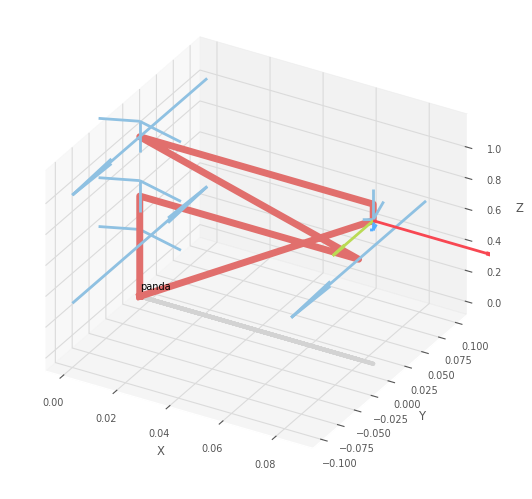

PyPlot3D backend, t = 2.499999999999999, scene:
  robot: Text(0.0, 0.0, 'panda')

<Figure size 640x480 with 0 Axes>

In [10]:
# Animate the trajectory of manipulator, panda, from qz to qr
qt = rtb.tools.trajectory.jtraj(qz, qr, 50)

qt_model = rtb.tools.trajectory.jtraj(panda_model.qz, panda_model.qr, 50)

# Plot the trajectory of the panda manipulator
panda.plot(qt.q, backend="pyplot", movie='Panda.gif')

panda_model.plot(qt_model.q, backend="pyplot", movie='Panda_Model.gif')